# Predict Crimes in Vancouver - Random Forest

We compare Random Forest Classification on four different models and tune hyperparameters on each:
1. Data without the `part_of_day` feature and without over-sampling.
2. Data without the `part_of_day` feature and with over-sampling.
3. Data with the `part_of_day` feature and without over-sampling.
4. Data with the `part_of_day` feature and with over-sampling.

## Research Sources
[1] Hossain, S., Abtahee, A., Kashem, I., Hoque, M.M., Sarker, I.H. (2020). Crime Prediction Using Spatio-Temporal Data. In: Chaubey, N., Parikh, S., Amin, K. (eds) Computing Science, Communication and Security. COMS2 2020. Communications in Computer and Information Science, vol 1235. Springer, Singapore. https://doi.org/10.1007/978-981-15-6648-6_22

[2] Rotaru, V., Huang, Y., Li, T. et al. Event-level prediction of urban crime reveals a signature of enforcement bias in US cities. Nat Hum Behav 6, 1056–1068 (2022). https://doi.org/10.1038/s41562-022-01372-0

[3] CSV to Shapefile with pyshp: https://glenbambrick.com/2016/01/09/csv-to-shapefile-with-pyshp/

[4] Machine Learning with Datetime Feature Engineering: Predicting Healthcare Appointment No-Shows: https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96

[5] Fine tuning a classifier in scikit-learn: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

## Libraries and Functions

In [1]:
import pandas as pd
pd.options.display.max_columns = None  # display all dataframe columns in the notebook
import numpy as np
import csv

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, plot_tree, export_graphviz

# transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Bayesian optimization over hyperparameters
from skopt.searchcv import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

# metrics
from sklearn.metrics import precision_recall_curve, roc_auc_score, balanced_accuracy_score, average_precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# visualize trees
from IPython.display import Image  
from six import StringIO
import pydotplus, graphviz

# over/under sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# pipeline
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline 

# display pipelines
from sklearn import set_config
set_config(display="diagram")

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)  # set standard figure size
%matplotlib inline

# suppress warnings
import warnings
warnings.simplefilter(action='ignore')

In [2]:
## taken from [4]

# calculate specificity
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y):
    return (sum(y)/len(y))

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_actual, (y_pred >= thresh))
    accuracy = accuracy_score(y_actual, (y_pred >= thresh))
    recall = recall_score(y_actual, (y_pred >= thresh))
    average_precision = average_precision_score(y_actual, (y_pred >= thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1 = f1_score(y_actual, (y_pred >= thresh))
    print('ROC AUC: %.3f'%auc)
    print('Balanced accuracy: %.3f'%balanced_accuracy)
    print('Accuracy: %.3f'%accuracy)
    print('Recall: %.3f'%recall)
    print('Average precision: %.3f'%average_precision)
    print('Specificity: %.3f'%specificity)
    print('F1: %.3f'%f1)
    print(' ')

In [3]:
## taken from [5]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

## Model 1

Use the data without the `part_of_day` feature, which reduces the data size to a quarter.

In [4]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification_without_partofday.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,1
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,0


In [5]:
# data size
crime_df_full.shape

(1120116, 9)

In [6]:
# data types
crime_df_full.dtypes

dauid             int64
neighbourhood    object
date             object
year              int64
month             int64
day               int64
weekday          object
season           object
crime             int64
dtype: object

In [7]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
crime                     int64
dtype: object

In [8]:
# set target column
target_col = 'crime'

We model on a single neighbourhood. We choose the `Central Business District` as, we saw earlier, it has by far the highest amount of reported crimes.

In [9]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(67665, 6)
(22555, 6)
(67665,)
(22555,)


In [10]:
## define variable types
nominal_cols = ['weekday','season']

# all variables
all_cols = list(X_train.columns)

In [11]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [ ]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True))
    ]
)

# define hyperparameter search space
param_dict = {'rf__max_depth': Integer(2,20, prior='uniform'),
              'rf__max_features': Real(0.1, 1., prior='uniform'),
              'rf__min_samples_leaf': Integer(1,500, prior='uniform'),
              'rf__min_samples_split': Integer(2,1000, prior='uniform'),
              'rf__n_estimators': Integer(5,500, prior='uniform'),
              'rf__ccp_alpha': Real(0., 0.3, prior='uniform'),
              'rf__max_samples': Real(0.1, 1., prior='uniform'),
              'rf__max_leaf_nodes': Integer(5,200, prior='uniform'),
              'rf__class_weight': Categorical(['balanced', 'balanced_subsample'])}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=5,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

In [14]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.5116755268584814

In [15]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('rf__ccp_alpha', 0.0),
             ('rf__class_weight', 'balanced_subsample'),
             ('rf__max_depth', 20),
             ('rf__max_features', 1.0),
             ('rf__max_leaf_nodes', 200),
             ('rf__max_samples', 1.0),
             ('rf__min_samples_leaf', 1),
             ('rf__min_samples_split', 53),
             ('rf__n_estimators', 5)])

In [16]:
# train the best model on the entire train set
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True, ccp_alpha=0.0, 
                                      class_weight='balanced_subsample', max_depth=20, max_features=1.0, 
                                      max_leaf_nodes=200, max_samples=1.0, min_samples_leaf=1, 
                                      min_samples_split=53, n_estimators=5))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'season'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=20, max_features=1.0,
                                        max_leaf_nodes=200, max_samples=1.0,
                                        min_samples_split=53, n_estimators=5,
                                        n_jobs=7, random_state=94))])

In [17]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

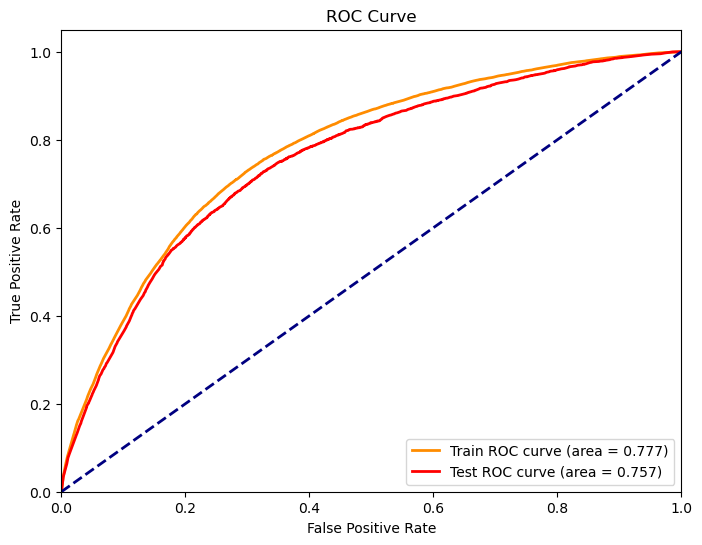

In [18]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color="darkorange", lw=lw, label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(fpr_test, tpr_test, color="red", lw=lw, label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [39]:
# standard threshold
thresh=0.5

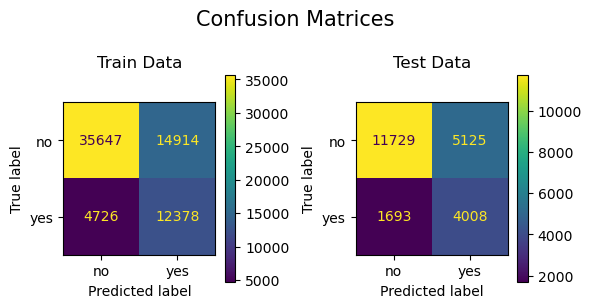

In [40]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [44]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.777
Balanced accuracy: 0.714
Accuracy: 0.710
Recall: 0.724
Average precision: 0.398
Specificity: 0.705
F1: 0.558
 


In [45]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.757
Balanced accuracy: 0.699
Accuracy: 0.698
Recall: 0.703
Average precision: 0.384
Specificity: 0.696
F1: 0.540
 


### Threshold Tuning, based on

#### F1 Score

In [38]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [46]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

In [48]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.520, F-score=0.541


In [50]:
# set threshold
thresh = thresholds[ix]
thresh

0.52

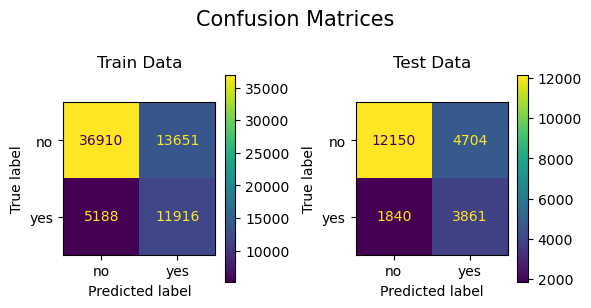

In [51]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [52]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.777
Balanced accuracy: 0.713
Accuracy: 0.722
Recall: 0.697
Average precision: 0.401
Specificity: 0.730
F1: 0.559
 


In [53]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.757
Balanced accuracy: 0.699
Accuracy: 0.710
Recall: 0.677
Average precision: 0.387
Specificity: 0.721
F1: 0.541
 


#### ROC AUC Curve

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

In [57]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.478421


In [58]:
# set threshold
thresh = best_thresh
thresh

0.47842097814231443

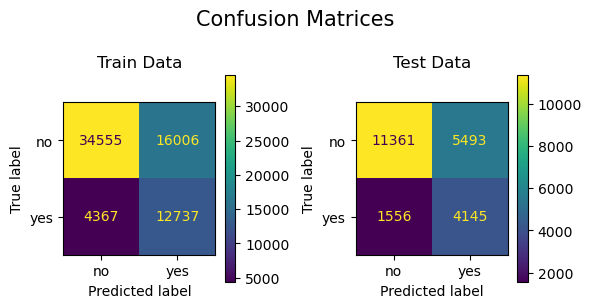

In [59]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [60]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.777
Balanced accuracy: 0.714
Accuracy: 0.699
Recall: 0.745
Average precision: 0.395
Specificity: 0.683
F1: 0.556
 


In [61]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.757
Balanced accuracy: 0.701
Accuracy: 0.687
Recall: 0.727
Average precision: 0.382
Specificity: 0.674
F1: 0.540
 


#### Precision-Recall Curve

In [62]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

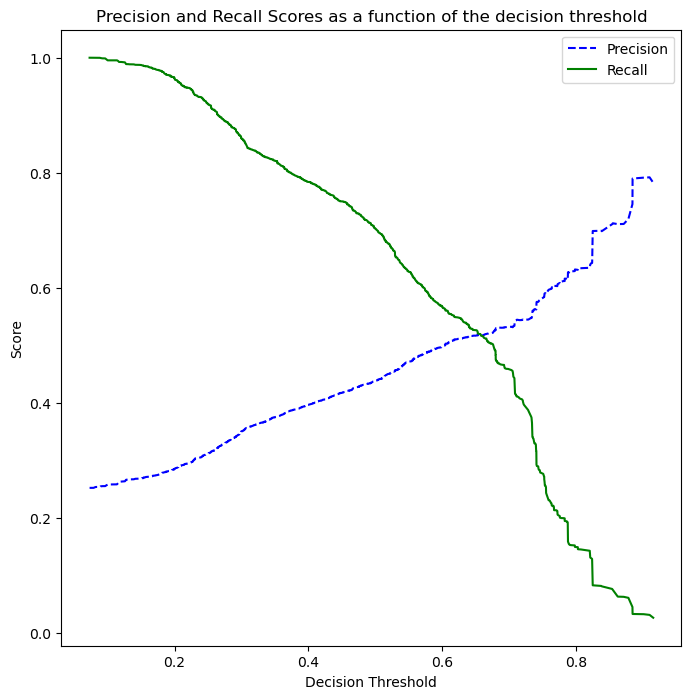

In [63]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [75]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.6581390994072756

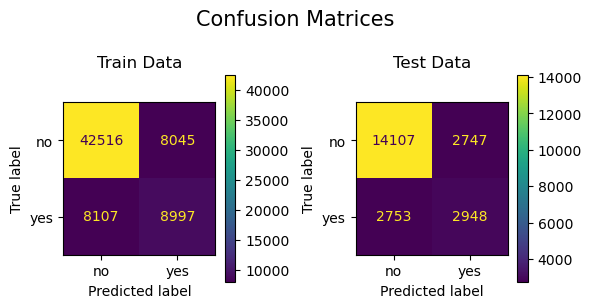

In [76]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [77]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.777
Balanced accuracy: 0.683
Accuracy: 0.761
Recall: 0.526
Average precision: 0.398
Specificity: 0.841
F1: 0.527
 


In [78]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.757
Balanced accuracy: 0.677
Accuracy: 0.756
Recall: 0.517
Average precision: 0.390
Specificity: 0.837
F1: 0.517
 


The threshold 0.48 yields the highest recall (0.727) and balanced accuracy (0.701).

The threshold 0.52 yields the highest F1 score (0.541).

The threshold 0.66 yields the highest accuracy (0.756), specificity (0.837), and average precision (0.390).

### Feature Importance

In [79]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

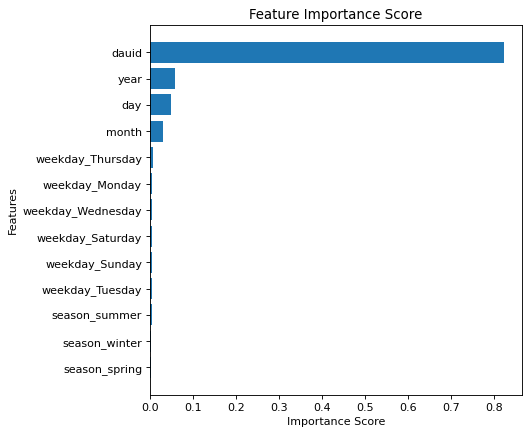

In [80]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

- `dauid` is by far the most important feature.
- `year`, `day`, and `month` have much lower importance.
- `season` and `weekday` are not important.

## Model 2

Model 1 with over-sampling.

In [123]:
from imblearn.pipeline import Pipeline

In [124]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification_without_partofday.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,1
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,0


In [125]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
crime                     int64
dtype: object

In [126]:
# set target column
target_col = 'crime'

In [127]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(67665, 6)
(22555, 6)
(67665,)
(22555,)


In [128]:
## define variable types
nominal_cols = ['weekday','season']

# all variables
all_cols = list(X_train.columns)

In [129]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [148]:
# class inbalance
inbalance = y_train.value_counts()[1]/y_train.value_counts()[0]
inbalance

0.338284448487965

In [ ]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('over', SMOTE()),
        #('under', RandomUnderSampler()),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True))
    ]
)

# define hyperparameter search space
param_dict = {'rf__max_depth': Integer(2,20, prior='uniform'),
              'rf__max_features': Real(0.1, 1., prior='uniform'),
              'rf__min_samples_leaf': Integer(1,500, prior='uniform'),
              'rf__min_samples_split': Integer(2,1000, prior='uniform'),
              'rf__n_estimators': Integer(5,500, prior='uniform'),
              'rf__ccp_alpha': Real(0., 0.3, prior='uniform'),
              'rf__max_samples': Real(0.1, 1., prior='uniform'),
              'rf__max_leaf_nodes': Integer(5,200, prior='uniform'),
              'rf__class_weight': Categorical(['balanced', 'balanced_subsample']),
              'over__sampling_strategy': Real(0.35, 1., prior='uniform')}
              #'under__sampling_strategy': Real(0.3, 0.6, prior='uniform')}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=5,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

In [153]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.5188566926050154

In [154]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('over__sampling_strategy', 0.35),
             ('rf__ccp_alpha', 0.0),
             ('rf__class_weight', 'balanced'),
             ('rf__max_depth', 16),
             ('rf__max_features', 0.896109200289075),
             ('rf__max_leaf_nodes', 169),
             ('rf__max_samples', 0.772298953895676),
             ('rf__min_samples_leaf', 1),
             ('rf__min_samples_split', 104),
             ('rf__n_estimators', 99)])

In [155]:
# train the best model on the entire train set
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('over', SMOTE(sampling_strategy=0.35)),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True, ccp_alpha=0.0, 
                                      class_weight='balanced', max_depth=16, max_features=0.896109200289075, 
                                      max_leaf_nodes=169, max_samples=0.772298953895676, min_samples_leaf=1, 
                                      min_samples_split=104, n_estimators=99))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'season'])])),
                ('over', SMOTE(sampling_strategy=0.35)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=16,
                                        max_features=0.896109200289075,
                                        max_leaf_nodes=169,
                                        max_samples=0.772298953895676,
                                        min_samples_split=104, n_estimators=99,
                                        n_jobs=7, random_state=94))])

In [156]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

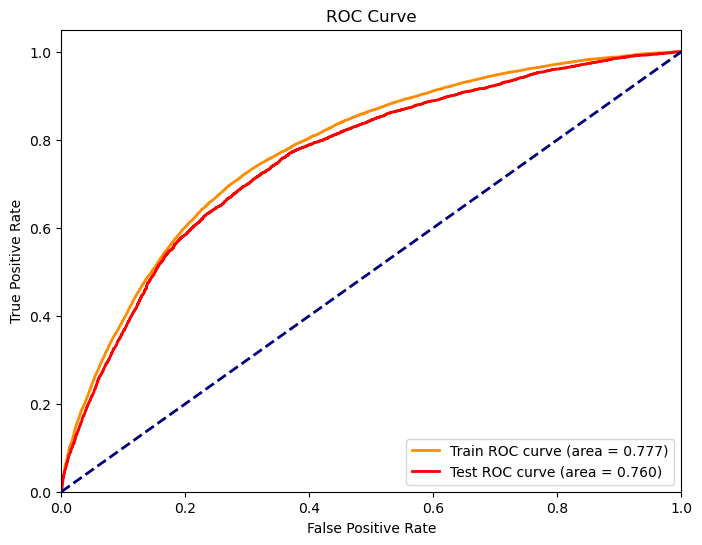

In [157]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color="darkorange", lw=lw, label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(fpr_test, tpr_test, color="red", lw=lw, label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [158]:
# standard threshold
thresh=0.5

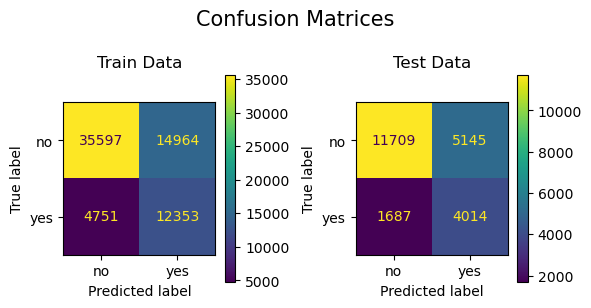

In [159]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [160]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.777
Balanced accuracy: 0.713
Accuracy: 0.709
Recall: 0.722
Average precision: 0.397
Specificity: 0.704
F1: 0.556
 


In [161]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.760
Balanced accuracy: 0.699
Accuracy: 0.697
Recall: 0.704
Average precision: 0.383
Specificity: 0.695
F1: 0.540
 


### Threshold Tuning, based on

#### F1 Score

In [162]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [163]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

In [164]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.550, F-score=0.543


In [165]:
# set threshold
thresh = thresholds[ix]
thresh

0.55

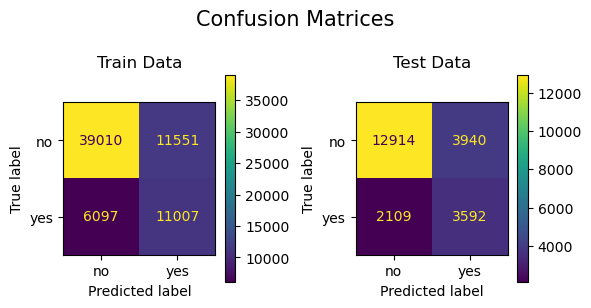

In [166]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [167]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.777
Balanced accuracy: 0.708
Accuracy: 0.739
Recall: 0.644
Average precision: 0.404
Specificity: 0.772
F1: 0.555
 


In [168]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.760
Balanced accuracy: 0.698
Accuracy: 0.732
Recall: 0.630
Average precision: 0.394
Specificity: 0.766
F1: 0.543
 


#### ROC AUC Curve

In [169]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

In [170]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.458738


In [171]:
# set threshold
thresh = best_thresh
thresh

0.4587378161655898

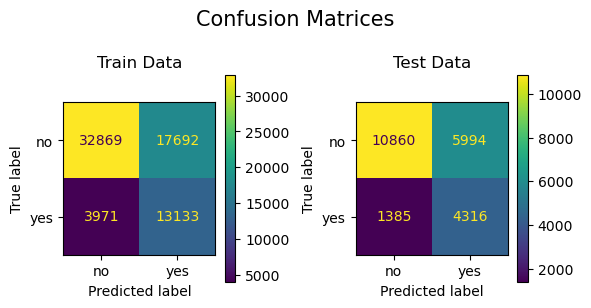

In [172]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [173]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.777
Balanced accuracy: 0.709
Accuracy: 0.680
Recall: 0.768
Average precision: 0.386
Specificity: 0.650
F1: 0.548
 


In [174]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.760
Balanced accuracy: 0.701
Accuracy: 0.673
Recall: 0.757
Average precision: 0.378
Specificity: 0.644
F1: 0.539
 


#### Precision-Recall Curve

In [175]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

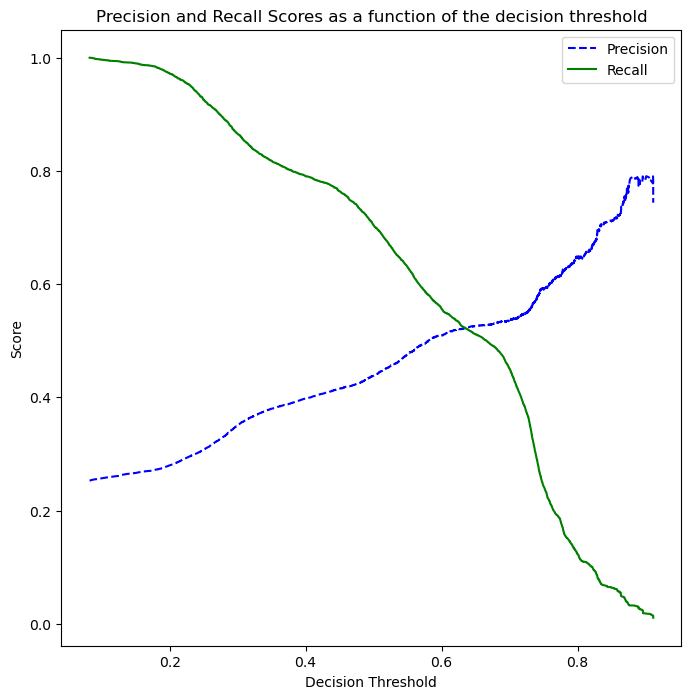

In [176]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [177]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.633897607760442

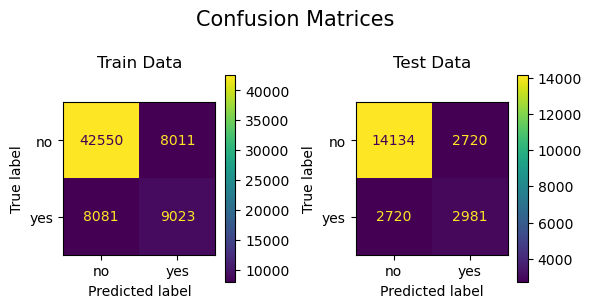

In [178]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [179]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.777
Balanced accuracy: 0.685
Accuracy: 0.762
Recall: 0.528
Average precision: 0.399
Specificity: 0.842
F1: 0.529
 


In [180]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.760
Balanced accuracy: 0.681
Accuracy: 0.759
Recall: 0.523
Average precision: 0.394
Specificity: 0.839
F1: 0.523
 


The threshold 0.46 yields the highest recall (0.757) and balanced accuracy (0.701).

The threshold 0.55 yields the highest F1 score (0.543) and average precision (0.394).

The threshold 0.63 yields the highest accuracy (0.759), specificity (0.839), and average precision (0.394).

### Feature Importance

In [181]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

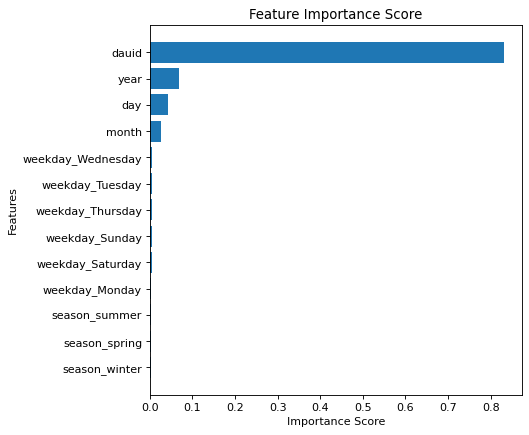

In [182]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

- `dauid` is by far the most important feature.
- `year`, `day`, and `month` have much lower importance.
- `season` and `weekday` are not important.

## Model 3

Use the data with the `part_of_day` feature, which increases the data size by a factor of four.

In [4]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,part_of_day,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,early morning,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,early morning,0
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,early morning,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,early morning,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,early morning,0


In [5]:
# data size
crime_df_full.shape

(4480464, 10)

In [6]:
# data types
crime_df_full.dtypes

dauid             int64
neighbourhood    object
date             object
year              int64
month             int64
day               int64
weekday          object
season           object
part_of_day      object
crime             int64
dtype: object

In [7]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
part_of_day              object
crime                     int64
dtype: object

In [8]:
# set target column
target_col = 'crime'

We model on a single neighbourhood. We choose the `Central Business District` as, we saw earlier, it has by far the highest amount of reported crimes.

In [9]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(270660, 7)
(90220, 7)
(270660,)
(90220,)


In [10]:
## define variable types

# nominal variables
nominal_cols = ['weekday','part_of_day','season']

# all variables
all_cols = list(X_train.columns)

In [12]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [ ]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True))
    ]
)

# define hyperparameter search space
param_dict = {'rf__max_depth': Integer(2,20, prior='uniform'),
              'rf__max_features': Real(0.1, 1., prior='uniform'),
              'rf__min_samples_leaf': Integer(1,500, prior='uniform'),
              'rf__min_samples_split': Integer(2,1000, prior='uniform'),
              'rf__n_estimators': Integer(5,500, prior='uniform'),
              'rf__ccp_alpha': Real(0., 0.3, prior='uniform'),
              'rf__max_samples': Real(0.1, 1., prior='uniform'),
              'rf__max_leaf_nodes': Integer(5,200, prior='uniform'),
              'rf__class_weight': Categorical(['balanced', 'balanced_subsample'])}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=5,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

In [14]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.24150774276812786

In [15]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('rf__ccp_alpha', 0.0),
             ('rf__class_weight', 'balanced'),
             ('rf__max_depth', 18),
             ('rf__max_features', 0.892048800348979),
             ('rf__max_leaf_nodes', 200),
             ('rf__max_samples', 0.7843646710890297),
             ('rf__min_samples_leaf', 1),
             ('rf__min_samples_split', 670),
             ('rf__n_estimators', 500)])

In [16]:
# train a model on the entire train set
pipe = pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True, ccp_alpha=0.0, 
                                      class_weight='balanced', max_depth=18, max_features=0.892048800348979, 
                                      max_leaf_nodes=200, max_samples=0.7843646710890297, min_samples_leaf=1, 
                                      min_samples_split=670, n_estimators=500))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'part_of_day',
                                                   'season'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=18,
                                        max_features=0.892048800348979,
                                        max_leaf_nodes=200,
                                        max_samples=0.7843646710890297,
                                        min_samples_split=670, n_estimators=500,
                                        n_jobs=7, random_state=94))])

In [17]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

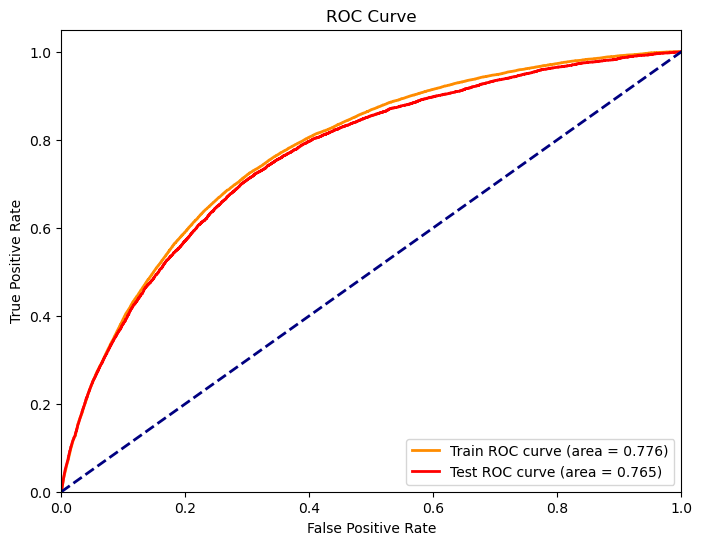

In [18]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(
    fpr_train,
    tpr_train,
    color="darkorange",
    lw=lw,
    label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(
    fpr_test,
    tpr_test,
    color="red",
    lw=lw,
    label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [19]:
# standard threshold
thresh=0.5

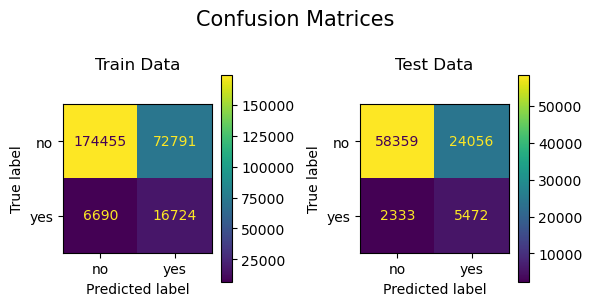

In [20]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [21]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.776
Balanced accuracy: 0.710
Accuracy: 0.706
Recall: 0.714
Average precision: 0.158
Specificity: 0.706
F1: 0.296
 


In [22]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.765
Balanced accuracy: 0.705
Accuracy: 0.708
Recall: 0.701
Average precision: 0.156
Specificity: 0.708
F1: 0.293
 


### Threshold Tuning, based on

#### F1 Score

In [23]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [24]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

In [25]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.677, F-score=0.321


In [26]:
# set threshold
thresh = thresholds[ix]
thresh

0.677

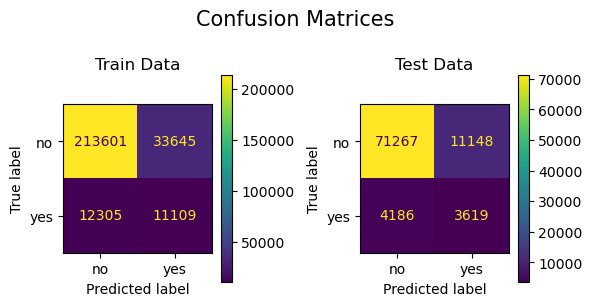

In [27]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [28]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.776
Balanced accuracy: 0.669
Accuracy: 0.830
Recall: 0.474
Average precision: 0.163
Specificity: 0.864
F1: 0.326
 


In [29]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.765
Balanced accuracy: 0.664
Accuracy: 0.830
Recall: 0.464
Average precision: 0.160
Specificity: 0.865
F1: 0.321
 


#### ROC AUC Curve

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

In [31]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.485842


In [32]:
# set threshold
thresh = best_thresh
thresh

0.4858419567596598

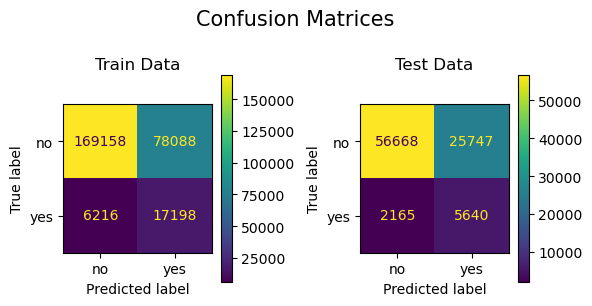

In [33]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [34]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.776
Balanced accuracy: 0.709
Accuracy: 0.689
Recall: 0.735
Average precision: 0.156
Specificity: 0.684
F1: 0.290
 


In [35]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.765
Balanced accuracy: 0.705
Accuracy: 0.691
Recall: 0.723
Average precision: 0.154
Specificity: 0.688
F1: 0.288
 


#### Precision-Recall Curve

In [36]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

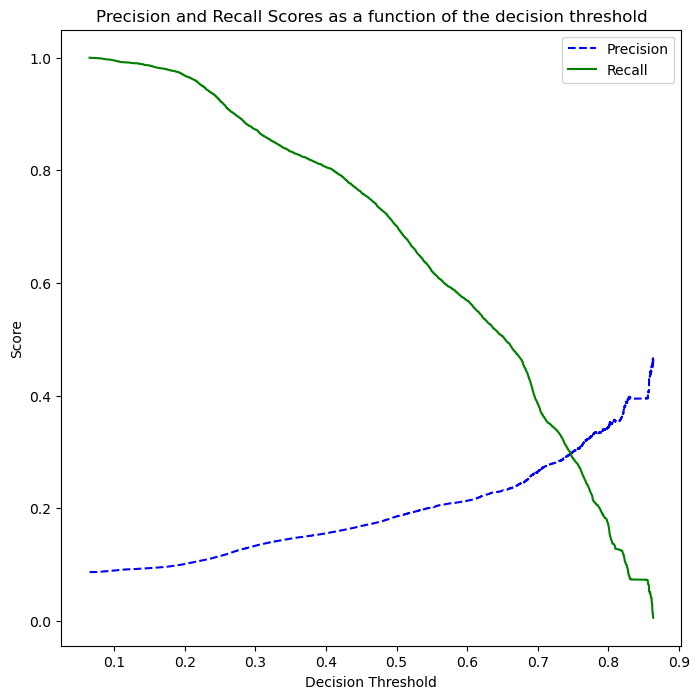

In [37]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [38]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.746846036207333

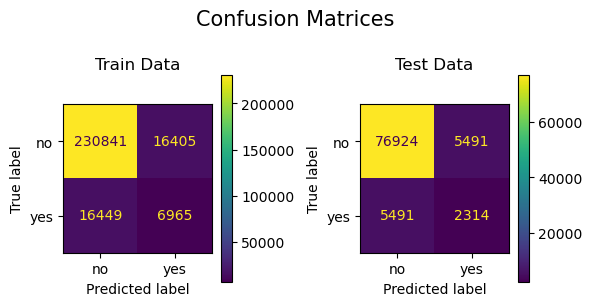

In [39]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [40]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.776
Balanced accuracy: 0.616
Accuracy: 0.879
Recall: 0.297
Average precision: 0.149
Specificity: 0.934
F1: 0.298
 


In [41]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.765
Balanced accuracy: 0.615
Accuracy: 0.878
Recall: 0.296
Average precision: 0.149
Specificity: 0.933
F1: 0.296
 


The threshold 0.49 yields the highest recall (0.723) and balanced accuracy (0.705).

The threshold 0.68 yields the highest F1 score (0.321) and average precision (0.160).

The threshold 0.75 yields the highest accuracy (0.878) and specificity (0.933).

### Feature Importance

In [42]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'part_of_day_early morning',
 'part_of_day_late morning',
 'part_of_day_night',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

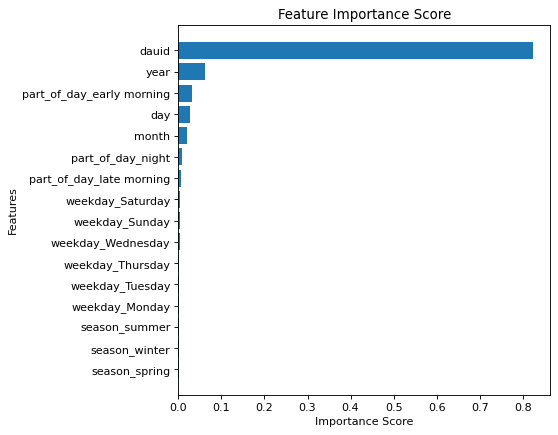

In [44]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

- `dauid` is by far the most important feature.
- `year`, `day`, `month`, and `part_of_day` have much lower importance.
- `season` and `weekday` are not important.

## Model 4

Model 3 with over-sampling.

In [4]:
from imblearn.pipeline import Pipeline

In [5]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,part_of_day,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,early morning,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,early morning,0
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,early morning,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,early morning,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,early morning,0


In [6]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
part_of_day              object
crime                     int64
dtype: object

In [7]:
# set target column
target_col = 'crime'

In [8]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(270660, 7)
(90220, 7)
(270660,)
(90220,)


In [9]:
## define variable types

# nominal variables
nominal_cols = ['weekday','part_of_day','season']

# all variables
all_cols = list(X_train.columns)

In [10]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [11]:
# class inbalance
inbalance = y_train.value_counts()[1]/y_train.value_counts()[0]
inbalance

0.09469920645834513

In [ ]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('over', SMOTE()),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True))
    ]
)

# define hyperparameter search space
param_dict = {'rf__max_depth': Integer(2,20, prior='uniform'),
              'rf__max_features': Real(0.1, 1., prior='uniform'),
              'rf__min_samples_leaf': Integer(1,500, prior='uniform'),
              'rf__min_samples_split': Integer(2,1000, prior='uniform'),
              'rf__n_estimators': Integer(5,500, prior='uniform'),
              'rf__ccp_alpha': Real(0., 0.3, prior='uniform'),
              'rf__max_samples': Real(0.1, 1., prior='uniform'),
              'rf__max_leaf_nodes': Integer(5,200, prior='uniform'),
              'rf__class_weight': Categorical(['balanced', 'balanced_subsample']),
              'over__sampling_strategy': Real(0.1, 1., prior='uniform')}
              #'under__sampling_strategy': Real(0.3, 0.6, prior='uniform')}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=5,
    scoring='average_precision',
    n_iter=50,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

In [54]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.24164108850553395

In [55]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('over__sampling_strategy', 0.1),
             ('rf__ccp_alpha', 0.0),
             ('rf__class_weight', 'balanced_subsample'),
             ('rf__max_depth', 11),
             ('rf__max_features', 1.0),
             ('rf__max_leaf_nodes', 200),
             ('rf__max_samples', 0.6631331770252713),
             ('rf__min_samples_leaf', 148),
             ('rf__min_samples_split', 2),
             ('rf__n_estimators', 232)])

In [12]:
# train the best model on the entire train set
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('over', SMOTE(sampling_strategy=0.1)),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True, ccp_alpha=0.0, 
                                      class_weight='balanced_subsample', max_depth=11, max_features=1.0, 
                                      max_leaf_nodes=200, max_samples=0.6631331770252713, min_samples_leaf=148, 
                                      min_samples_split=2, n_estimators=232))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'part_of_day',
                                                   'season'])])),
                ('over', SMOTE(sampling_strategy=0.1)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=11, max_features=1.0,
                                        max_leaf_nodes=200,
                                        max_samples=0.6631331770252713,
                                        min_samples_leaf=148, n_estimators=232,
                                        n_jobs=7, random_state=94))])

In [13]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

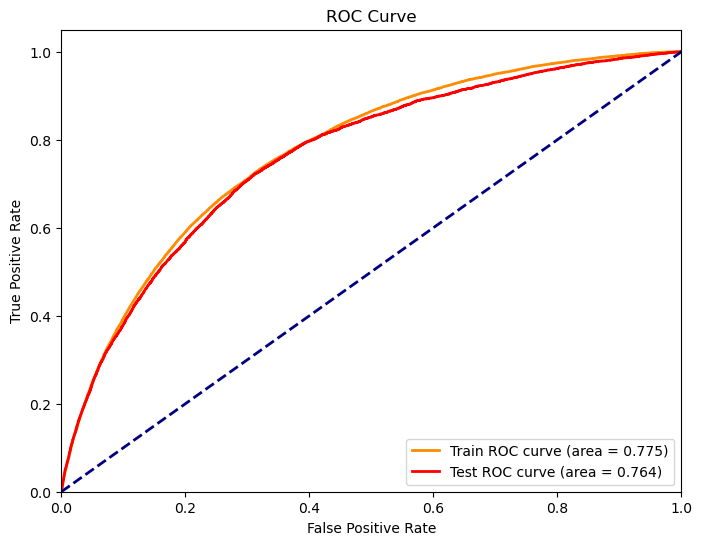

In [14]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(
    fpr_train,
    tpr_train,
    color="darkorange",
    lw=lw,
    label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(
    fpr_test,
    tpr_test,
    color="red",
    lw=lw,
    label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [15]:
# standard threshold
thresh=0.5

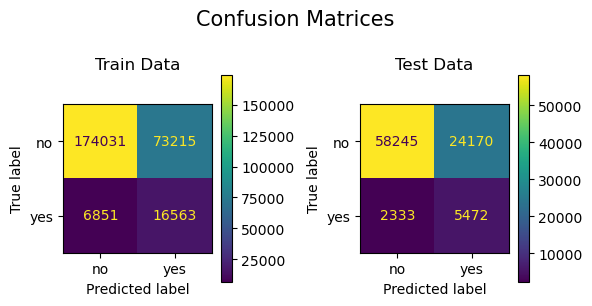

In [16]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [17]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.775
Balanced accuracy: 0.706
Accuracy: 0.704
Recall: 0.707
Average precision: 0.156
Specificity: 0.704
F1: 0.293
 


In [18]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.764
Balanced accuracy: 0.704
Accuracy: 0.706
Recall: 0.701
Average precision: 0.155
Specificity: 0.707
F1: 0.292
 


### Threshold Tuning, based on

#### F1 Score

In [19]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [20]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

In [21]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.667, F-score=0.319


In [22]:
# set threshold
thresh = thresholds[ix]
thresh

0.667

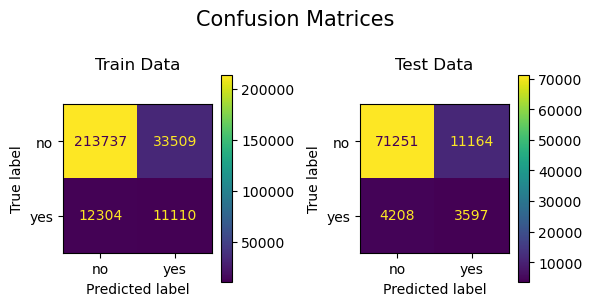

In [23]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [24]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.775
Balanced accuracy: 0.669
Accuracy: 0.831
Recall: 0.475
Average precision: 0.164
Specificity: 0.864
F1: 0.327
 


In [25]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.764
Balanced accuracy: 0.663
Accuracy: 0.830
Recall: 0.461
Average precision: 0.159
Specificity: 0.865
F1: 0.319
 


#### ROC AUC Curve

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

In [27]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.488244


In [28]:
# set threshold
thresh = best_thresh
thresh

0.4882443006820539

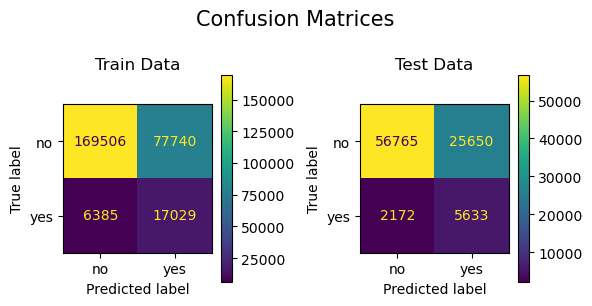

In [29]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [30]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.775
Balanced accuracy: 0.706
Accuracy: 0.689
Recall: 0.727
Average precision: 0.154
Specificity: 0.686
F1: 0.288
 


In [31]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.764
Balanced accuracy: 0.705
Accuracy: 0.692
Recall: 0.722
Average precision: 0.154
Specificity: 0.689
F1: 0.288
 


#### Precision-Recall Curve

In [32]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

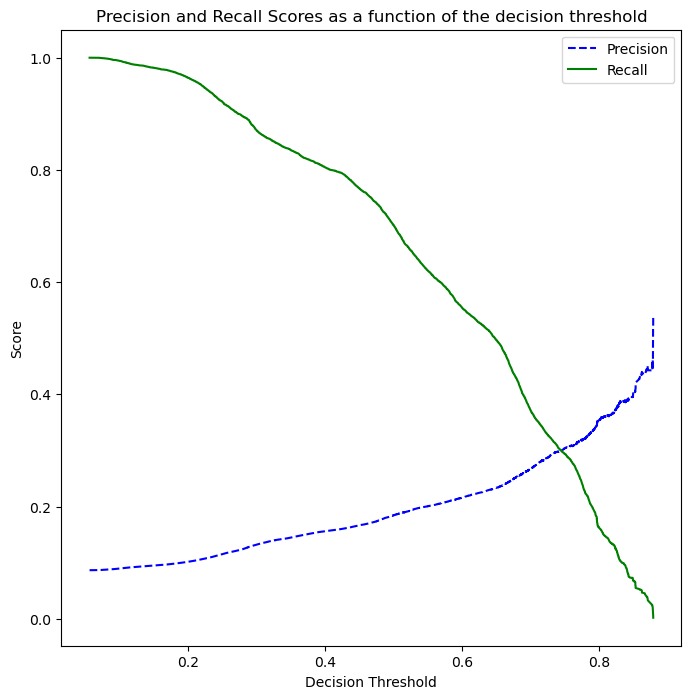

In [33]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [34]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.7445238757586078

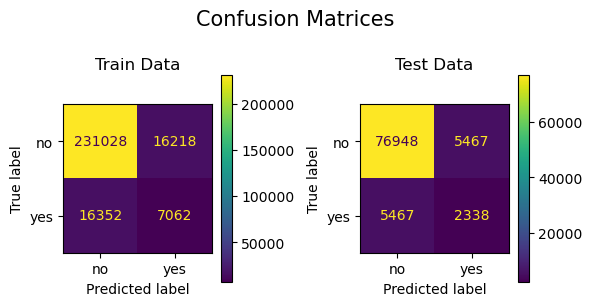

In [35]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [36]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

ROC AUC: 0.775
Balanced accuracy: 0.618
Accuracy: 0.880
Recall: 0.302
Average precision: 0.152
Specificity: 0.934
F1: 0.302
 


In [37]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

ROC AUC: 0.764
Balanced accuracy: 0.617
Accuracy: 0.879
Recall: 0.300
Average precision: 0.150
Specificity: 0.934
F1: 0.300
 


The threshold 0.49 yields the highest recall (0.722) and balanced accuracy (0.705).

The threshold 0.67 yields the highest F1 score (0.319) and average precision (0.159).

The threshold 0.74 yields the highest accuracy (0.879) and specificity (0.934).

### Feature Importance

In [38]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'part_of_day_early morning',
 'part_of_day_late morning',
 'part_of_day_night',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

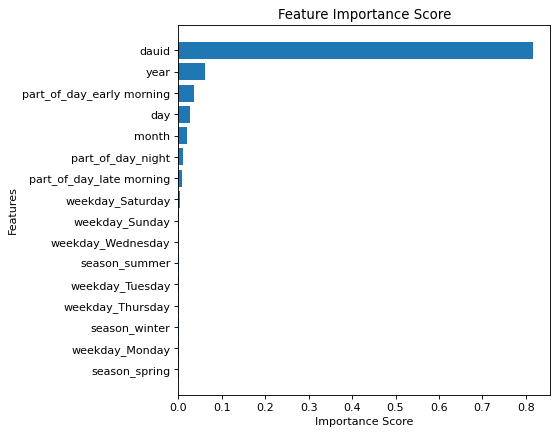

In [39]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

- `dauid` is by far the most important feature.
- `year`, `day`, `month`, and `part_of_day` have much lower importance.
- `season` and `weekday` are not important.

## Results

- We choose to predict crime in the `Central Business District` as it has by far the highest amount of reported crimes.


- We compared Random Forest Classification on four different models and tuned hyperparameters on each:
    1. Data without the `part_of_day` feature and without over-sampling.
    2. Data without the `part_of_day` feature and with over-sampling.
    3. Data with the `part_of_day` feature and without over-sampling.
    4. Data with the `part_of_day` feature and with over-sampling.
    
    
- Model 2 is the best model with the following regard:
    - The threshold 0.46 yields the highest recall (0.757) and balanced accuracy (0.701).
    - The threshold 0.55 yields the highest F1 score (0.543) and average precision (0.394).
    

- Model 3 and 4 are very similar, and they are the best models with the following regard:
    - The threshold 0.74 yields the highest accuracy (0.879) and specificity (0.934).
    - They yield the higest ROC AUC score (0.7640).
    

- The dissemination block is by far the most important feature. Year, day, month, and the part of the day have much lower importance. Season and weekday are not important.

## Next Steps
In the future, we plan to:
- use time series analysis to determine long-term changes and seasonal components of crime
- analyze over-/under-sampling
- incorporate the location of police stations
- incorporate demographic, social, and economic neighborhood characteristics